In [158]:
# Libraries to required
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from  ast import literal_eval
import seaborn as sns
from wordcloud import WordCloud
import re
import warnings 
warnings.filterwarnings('ignore')

def yes_no_encoding(df,field):
    return df[field].map({'Yes':1,'No':0})

def cleaner(df,field,na_val='unknown'):
    df[field].fillna(na_val,inplace=True)
    df[field].replace('-',na_val,inplace=True)
    df[field].replace('NaN',na_val,inplace=True)
    df[field]=df[field].apply(lambda x:x.replace(" ",""))
    return df[field]

def num_cleaner(df,field):
    return df[field].apply(lambda x:int(x.replace(",","")))

def str_tolist(df,field):
    return df[field].apply(lambda x:str(x).split(","))

def count_length(df,field):
    return df[field].apply(lambda x: len(str(x).replace('[','').replace(']','').split(',')) if x is not np.NaN else x)

def reduce_cardinality(df, field, threshold = 10):
    
    """
    reduce_cardinality >>> to keep category with enoug counts, trandform other type as "Others"

    """
    value_counts = df[field].astype(str).value_counts()
    all_categories = value_counts.index.tolist()
    keep_categories = (value_counts[value_counts > threshold]).index.tolist()
    
    remove_categories = list(set(all_categories) - set(keep_categories))
    reduce_card_dict = dict(zip(all_categories, all_categories))
    reduce_card_dict_2 = dict(zip(remove_categories, ['Other']*len(remove_categories)))
    reduce_card_dict.update(reduce_card_dict_2)

   # card_dict_filename = '{0}{1}.csv'.format(woe_dict_dir, 'card_dict_feature_{0}'.format(field))
    card_dict_df = pd.DataFrame(list(reduce_card_dict.items()), columns = ['raw categories', 'mapped category'] )
    #card_dict_df.to_csv(card_dict_filename, index = False)
    card_dict_df = card_dict_df.set_index('raw categories').to_dict()['mapped category']
    woe_field = "woe_"+field
    df[woe_field] = df[field].apply(lambda x: card_dict_df[x] if x in card_dict_df.keys() else np.nan)
    
    return df[woe_field]

def UVA_category(data,cat_group,max_cat=20):
    '''
    Univariate_Analysis_categorical
    takes a group of variables (category) and plot/print all the value_counts and barplot.
    '''
    # setting figure_size
    size = len(cat_group)
    plt.figure(figsize = (8*size,4), dpi = 100)

    # for every variable
    for j,i in enumerate(cat_group):
        norm_count = data[i].value_counts(normalize = True)[:max_cat]
        n_uni = data[i].nunique()
  
        #Plotting the variable with every information
        plt.subplot(1,size,j+1)
        sns.barplot(y=norm_count.index ,x=norm_count*100, order = norm_count.index,palette='deep')
        plt.ylabel('{}'.format(i).capitalize(), fontsize = 20)
        plt.xlabel('fraction/percent'.capitalize(), fontsize = 20)
        plt.title('Distribution of {}'.format(i))

def UAEnumerical(data,cont_group):
    '''
    Univariate_Analysis_Numerical
    takes a group of variables (Continous) and plot/print all the value_counts and barplot.
    '''
    size=len(cont_group)
    plt.figure(figsize=(7*size,3),dpi=100)
    #looping for each variable
 
    for i,j in enumerate(cont_group):
        # calculating descriptives of variable
        _min=data[j].min()
        _max=data[j].max()
        _range=data[j].max()-data[j].min()
        mean=data[j].mean()
        median=data[j].median()
        stddev=data[j].std()
        
        # calculating points of standard deviation
        points = mean-stddev, mean+stddev
        
        #Plotting the variable with every information   
        plt.subplot(1,size,i+1)
        sns.kdeplot(data[j],color='orange',shade=True,bw=0.5)
        sns.lineplot(x=points,y=[0,0],color = 'black',label="std_dev")
        sns.scatterplot([_min,_max],[0,0],color='green',label="Min-Max")
        sns.scatterplot([mean], [0],color='red', label = "mean")
        sns.scatterplot([median],[0], color='yellow', label = "median")
        plt.xlabel('{}'.format(j), fontsize = 10)
        plt.ylabel('Density')
        plt.title('std_dev = {}; range = {}\nmean = {}; median = {}'.format((round(points[0],2),round(points[1],2)),
                                                                                                       (round(_min,2),round(_max,2),round(_range,2)),
                                                                                                       round(mean,2),
                                                                                                       round(median,2)))
        
def build_word_cloud(df,field):
    df[field].fillna('unknown',inplace=True)
    df[field]= df[field].apply(lambda x:x.replace(" ",""))
    text = " ".join(cat for cat in df[field])
    word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)
    # Display the generated Word Cloud
    plt.figure(figsize=(10,15))
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    
def build_word_cloud_listed(df,field):
    '''
    This Function is used to build Word cloud using data frame and field where the Entry must be a list
    '''
    field_list=[]
    for i in range(len(df)):
            try:
                field_list.extend(df['dish_liked'][i].split(','))
            except:
                pass
        
    text = " ".join(cat for cat in field_list)
    word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)
    # Display the generated Word Cloud
    plt.figure(figsize=(10,12))
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()   

def clean_text(text):
    text = re.sub(r'[^a-zA-Z]', '', text)
    return text.lower()

def clean_number(number):
    try:
        number=re.sub(r'[^0-9]', '', number)
        return float(number)
    except:
        return number
    
# Importing Data 
df= pd.read_csv('zomato.csv')
df.drop(columns=['url','address','phone','reviews_list'],axis=1,inplace=True)
# Label Encoding 
df['online_order']=yes_no_encoding(df,'online_order')
df['book_table']=yes_no_encoding(df,'book_table')

#changing column Names
df.rename(columns={'rest_type':'type','approx_cost(for two people)':'cost','menu_item':'menu'},inplace=True)

df['rate']=cleaner(df,'rate')
df['rate']=df['rate'].apply(lambda x: x.replace('NEW','unknown'))
df['rate']=df['rate'].apply(lambda x: float(x[:3]) if x!='unknown' else np.nan )

# Feacture Extraction and cleaning
df['name']=df['name'].apply(lambda x : clean_text(x))
df['menu']=df['menu'].apply(lambda x : x if x!='[]' else np.nan)
df['menu']=df['menu'].apply(lambda x : x.replace('[','').replace(']','').replace("'","") if x is not np.nan else x )
df['menu_count']=count_length(df,'menu')
df['dish_liked_count']=count_length(df,'dish_liked')
df['cuisines_count']=count_length(df,'cuisines')


In [159]:
df['cost']=df['cost'].apply(lambda x : clean_number(x))

In [160]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51717 entries, 0 to 51716
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              51717 non-null  object 
 1   online_order      51717 non-null  int64  
 2   book_table        51717 non-null  int64  
 3   rate              41665 non-null  float64
 4   votes             51717 non-null  int64  
 5   location          51696 non-null  object 
 6   type              51490 non-null  object 
 7   dish_liked        23639 non-null  object 
 8   cuisines          51672 non-null  object 
 9   cost              51371 non-null  float64
 10  menu              12100 non-null  object 
 11  listed_in(type)   51717 non-null  object 
 12  listed_in(city)   51717 non-null  object 
 13  menu_count        12100 non-null  float64
 14  dish_liked_count  23639 non-null  float64
 15  cuisines_count    51672 non-null  float64
dtypes: float64(5), int64(3), object(8)
memor

## Univarient Analysis

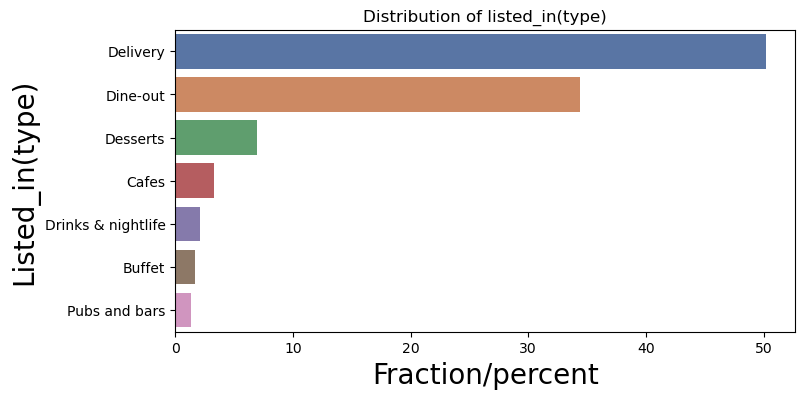

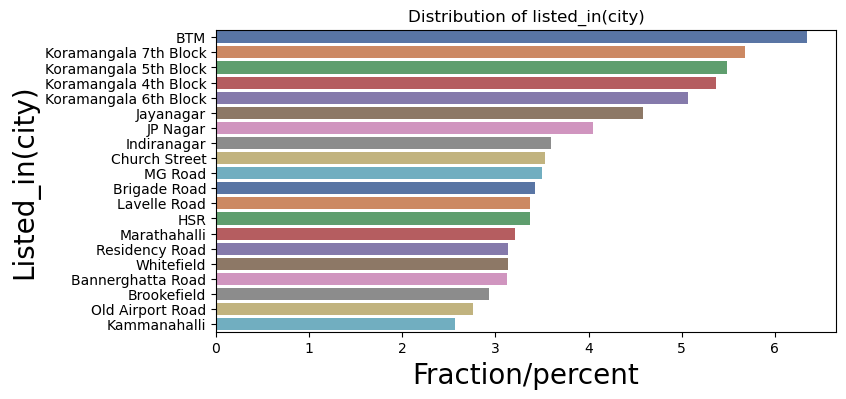

In [108]:
for col in ['listed_in(type)','listed_in(city)']:
    UVA_category(df,[col])

* In listed_in(type) column has a max Distrubation of 50% in Delivery Type
* In listed_in(city) BTM and Kormangala is the hot zone which has max no of entries
        (BTM layout is surrounded by kormangala, jayanagar and JP nagar so we can say most of the people near BTM 
        tend to Cook less and Prefer Hotel more 😉)  

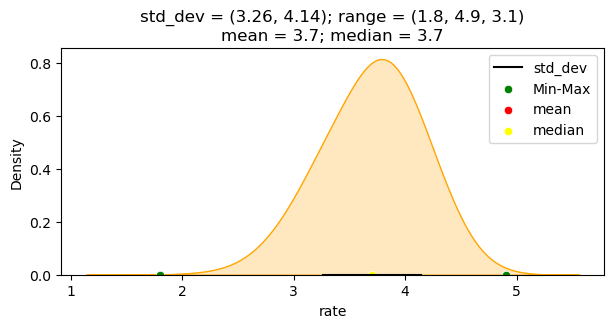

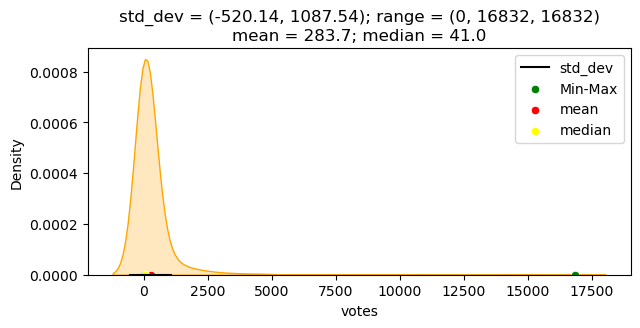

In [109]:
for col in ['rate', 'votes']:
    UAEnumerical(df,[col])

* Rate column is Normally Distributed (Target Column)
* Votes are Right skewed 
        (We need to look for bi varient on Votes and Rate to find if the Rating is good with most voted Hotel)

# Most Liked_ dish

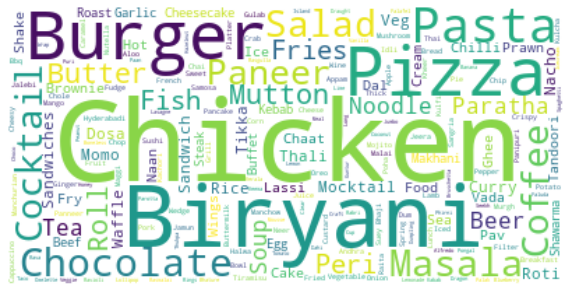

In [50]:
build_word_cloud_listed(df,'dish_liked')


* Dish_Liked most Important Column, As we can see Chicken is the Dish which is Most liked and also Biryani 
       (Non-vegetarian would be most liked type if we consider veg v/s non-veg )

# Most repated Name

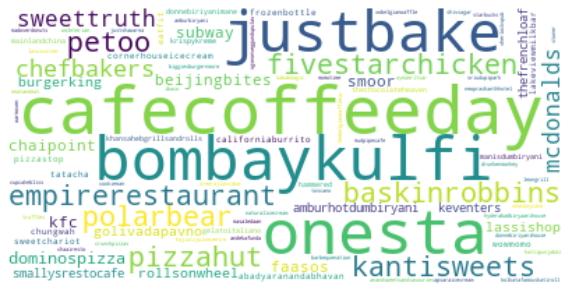

In [51]:
build_word_cloud(df,'name')

* Name plays a important role in Hotel industries as we can see "Cafe coffee day" and "Bombaykulfi" is most Repeated name 
        (a secret "Cafe coffee day" provided a 30 min free wifi even Before Jio was lanched 😉)

# Most Repated Location

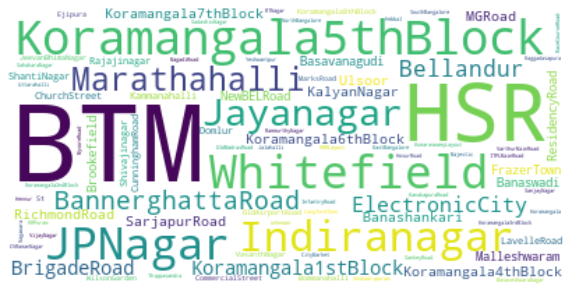

In [52]:
build_word_cloud(df,'location')

* Actual Location of the Hotel, As we saw above most of them are BTM and around BTM

# Most Famous Cuisines

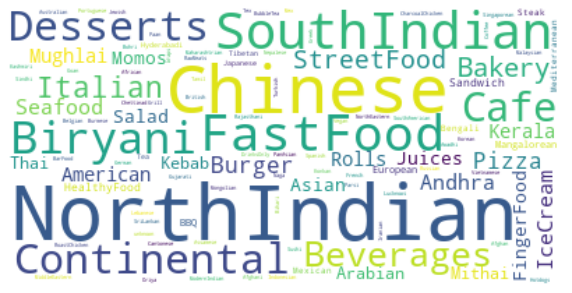

In [53]:
build_word_cloud(df,'cuisines')

* Cuisines as we can see "Nouth Indian and Chinese" are most avalible Cuisines in Bengaluru 

# Most approched Type

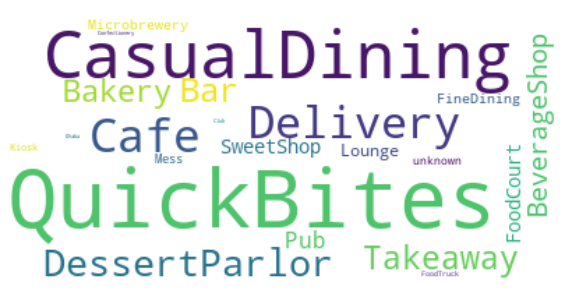

In [87]:
build_word_cloud(df,'type')

* Quick Bites and Casual Dining are Most Preffered/Followed 

# Bi-Varient Analysis

<AxesSubplot:xlabel='rate', ylabel='votes'>

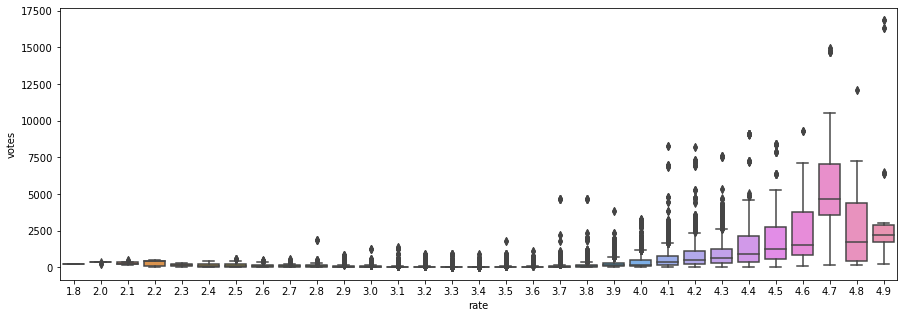

In [132]:
plt.figure(figsize=(15,5))
sns.boxplot(df['rate'],df['votes'])

* As we can see the Median value of max rating tend to be with highest no of votes
        (More votes says Good higher Rating)

<AxesSubplot:xlabel='rate', ylabel='menu_count'>

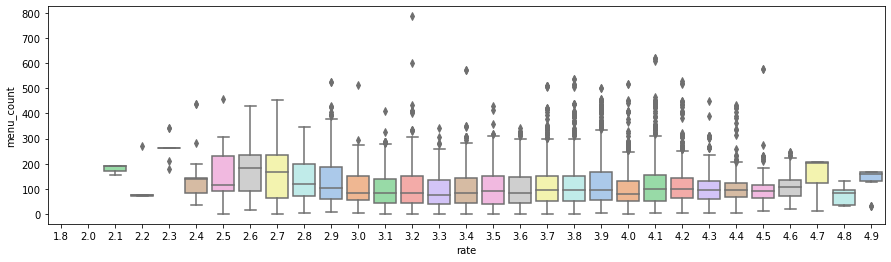

In [167]:
plt.figure(figsize=(15,4))
sns.boxplot(df['rate'],df['menu_count'],palette="pastel")

* No Much Difference with respect to Menu Count **Drop Menu and count Menu 

<AxesSubplot:xlabel='rate', ylabel='dish_liked_count'>

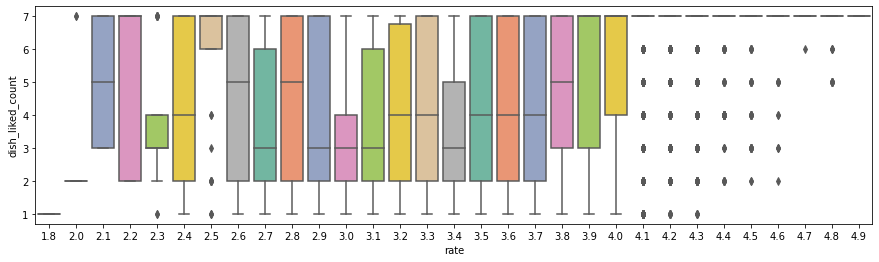

In [173]:
plt.figure(figsize=(15,4))
sns.boxplot(df['rate'],df['dish_liked_count'],palette="Set2")

* Rating are high with Max dish_liked_count

<AxesSubplot:xlabel='rate', ylabel='cuisines_count'>

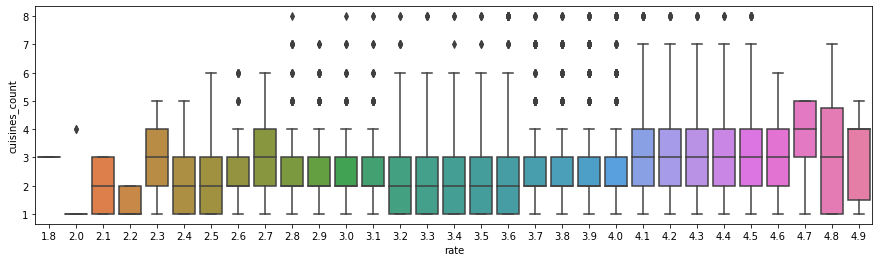

In [177]:
plt.figure(figsize=(15,4))
sns.boxplot(df['rate'],df['cuisines_count'],palette="husl")

* Higher nubmer of cuisines_count is also increasing the Rating

<AxesSubplot:xlabel='rate', ylabel='cost'>

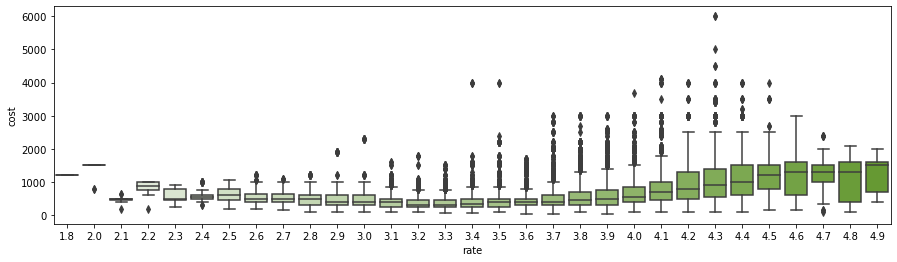

In [184]:
plt.figure(figsize=(15,4))
sns.boxplot(df['rate'],df['cost'],palette='light:#6A2')